<center>
<img width="150" src="figures/logo-universeh.png" alt="log universeh" />   &nbsp;&nbsp;<img width="300" src="figures/logo-enm.png" alt="log ENM" />&nbsp;&nbsp;<img width="150" src="figures/logo-inpt.png" alt="log INPT" />&nbsp;&nbsp;<img width="250" src="figures/logo-univ-toulouse.jpg" alt="log univ-toulouse" />
</center>


<!-- Template 
Auteur: Olivier Pannekoucke
Date: 27/09/2017
Description: 
   Introduction aux notebook jupyter et à la création/valorisation d'un travail scientifique.
-->
<center>
<h1> Wind power plant prediction in assymetric market</h1>
<h5>Olivier Pannekoucke (INPT-ENM, CNRM, CERFACS)</h5>
</center>

<h3 style="font-variant:small-caps;"><a class="tocSkip"><center>Summary</center></h3>
<div style="margin:0 50px 0 50px">
<p style="background:rgb(230,230,255)">
The aims of this notebook is to introduce weather prediction from a simple and classical dynamical model, with a focus on application in wind power production. A dynamics introduces to weather forecasting as done in operational centers. This leads to compute synthetic data for populated a climate and support the economical study, where a wind and a wind power production is deduced from the state of the idealized weather and its forecast. The goal is to predict the power production to specify into the contact 6 hours ahead (24h hours ahead in real life). A data assimilation framework is introduced to provide an ensemble of forecast estimation of the uncertainty. Different strategies of contract definition of the predicted power are proposed and computed from the synthetic climatological data, then evaluated over a new period.
    </p>
<p>
<b>keywords</b>: <i> Nature, weather prediction, wind power plant.</i>
</p>
</div>

## **1. Introduction**

Risk management of weather sensitive applications is adressed here considering wind power plant production prediction.

Several configurations can be encountered so to provide the gain or its estimation depending on the amount of information available.


**Producer profit ($\Pi$) when the production is known**

For an electrical production of PE, sold at a price of $p$, the gain for the producer is 
$$\Pi = pPE,$$

**Profit given from a perfect prediction of wind speed**

In the case of wind energy, the production can be deduced from the wind strength $PE(FF)$, where $FF$ denotes the wind magnitude. Thus, a perfect wind forecast, $FF_t$ leads to a perfect forecast of the expected production, such as 
$$\Pi = pPE(FF_t),$$

### **1.1) Profit under uncertainty**

**Expected profit knowing the past (time serie of past profit)**

One can ask the question of what the producer can earn in the future. For example, what is the gain that will be realized from today to tomorrow?
Without additional information, the expected gain can be evaluated by considering the climate -- past gains, i.e. 
$$\Pi_{clim.} = p\mathbb{E}(PE),$$

**Expected profit from an imperfect wind speed forecast**

In the case of an imperfect forecast, the expected gain is then obtained using the optimal estimate of the production knowing the expected wind strength $FF_f$, i.e. 
$$\Pi_e = p\mathbb{E}(PE/FF_f),$$
where $\mathbb{E}(\cdot/FF_f)$ stands for the conditional expectation knowing the wind speed.

**Expected profit from an ensemble of imperfect wind speed**

In the case where the forecast is probabilistic, the best estimate of the gain is obtained as 
$$\Pi_{e,ens.} = \mathbb{E}_{FF_f}\left[p\mathbb{E}(PE/FF_f)\right],$$

### **1.2) Penalties on over/under estimation of the true production**

Since the transmission system is sensitive to overloading, it is necessary to avoid underestimating the forecasted production, which leads to a forecasted value that is lower than the value actually observed, with the risk of injecting too much energy simultaneously into the system.

Thus, the **contract** is that the producer commits to a given production $PE_c$, the contracted production.

Thus, the transmission system operator can impose a very high penalty for underestimating actual generation (*i.e. when $PE-PE_c\geq 0$*), such that the loss to the generator is given by 
$$L_\text{under estim.}(PE_c,PE) = k_1 (PE-PE_c)^+, \text{ with } k_1>0,$$
where $(u)^+ = max(u,0)$

On the other hand, overestimating its production can also have a negative effect, by risking not meeting the overall demand.
Here again, the network operator can impose a penalty, possibly a little less severe. 

$$L_\text{over estim.}(PE_c,PE) = k_2 (PE_c-PE)^+, \text{ with } k_2>0$$

The total gain taking into account the penalties is then written as 

\begin{eqnarray}
\Pi &=& pPE -L(PE_c, PE) \\
&=& pPE -  k_1 (PE-PE_c)^+ - k_2 (PE_c-PE)^+.
\end{eqnarray}

with 
$$
L(PE_c, PE)=  k_1 (PE-PE_c)^+ + k_2 (PE_c-PE)^+.
$$


In [1]:
# Load required 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import valeco

fig_num = 0
def Fignum():
    global fig_num
    fig_num +=1
    return f"Fig. {fig_num} : "

In [2]:
relu = lambda x:np.maximum(x,0)

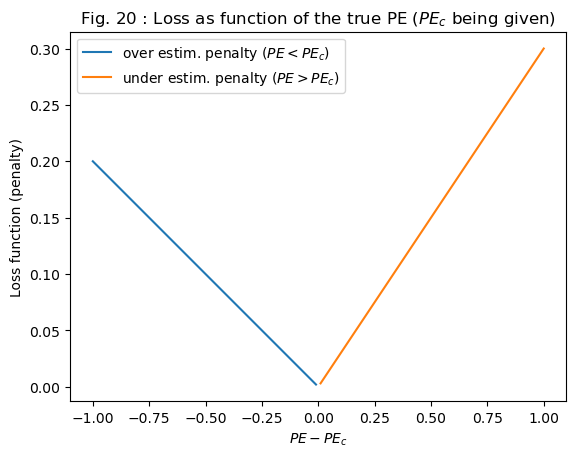

In [95]:
k1, k2 = 0.3, 0.2
PE = np.linspace(-1, 1, 100)

def loss(PEc, PE):
    '''
    Assymmetric Loss function including penalty to secure under-estimation of energy production
    '''
    return k1*relu(PE-PEc)+k2*relu(PEc-PE)
PEc = 0.
#plt.plot(PE,loss(0, PE))
delta = PE-PEc
plt.plot(delta[delta<=0],loss(0,PE[delta<=0]), label='over estim. penalty ($PE<PE_c$)')
plt.plot(delta[delta>=0],loss(0,PE[delta>=0]), label='under estim. penalty ($PE>PE_c$)')
plt.legend()
plt.xlabel('$PE-PE_c$')
plt.ylabel('Loss function (penalty)')
plt.title(Fignum()+"Loss as function of the true PE ($PE_c$ being given)");
plt.savefig("./figures/fig-assymetric-penalties.png")

### **1.3) Economical value of weather information**

The value of an information can be represented as the expectation of the difference of gain when considering the information or not, and performed over a **time period of validation** , *i.e.*
$$VI = \mathbb{E}_{time}[\text{gain with information}] -  \mathbb{E}_{time}[\text{gain without information}].$$

Hence, several value of informations can be considered for wind power plant:


**information of deterministic forecast vs. climate**

$$VI = \mathbb{E}_{time}[\Pi_e] -  \mathbb{E}_{time}[\Pi_{clim.}] \equiv \mathbb{E}_{time}[\Pi_e] -  \Pi_{clim.}$$


**information of ensemble of forecasts vs. climate**

$$VI = \mathbb{E}_{time}[\Pi_{e,ens.}] -  \Pi_{clim.}$$

**information of ensemble of forecasts vs. deterministic prediction**

$$VI = \mathbb{E}_{time}[\Pi_{e,ens.}] - \mathbb{E}_{time}[\Pi_e] $$


## **2. Idealized world : the "nature run"**

We consider an idealized world introduced so to mimic real numerical weather prediction suite, but at a much lower cost: here one year of simulation only takes few seconds ! 

In this idealized atmosphere, the weather is entirely known from three scalars $\mathbf{x}=(x_1,x_2,x_3)$ whose meaning is not important for our work. Morover, the atmosphere is govern by a dynamics given by 
$$\frac{d\mathbf{x}}{dt} = f(\mathbf{x}),$$
so that, from the state $\mathbf{x}(t)$ at time $t$, the state at time $t+dt$ is given by 
$$\mathbf{x}(t+dt) = \mathbf{x}(t) + dt f(\mathbf{x}(t)).$$

Hence, a sequential algorithm can forecast the time evolution of the simplified atmosphere, starting from a given initial state $\mathbf{x}(0)$.

This idealized atmosphere is considered as beeing the Nature, and a long simulation of this nature from a startgin point is a Nature run.

In [4]:
nature = valeco.Nature()

### **2.1 Nature observed in an idealized world**

In this part, we compute the evolution of an idealized atmosphere, where the time step is of 15 minutes (or 0.25 hour). 

In [5]:
nature.dt # corresponds to a quarter hour that is 15 minutes of atmospheric real time evolution.

0.25

In [6]:
# Build a typical state for the idealized atmosphere (long run computation from a random state.)
x0 = nature.typical_state()

In [7]:
window_6h = np.arange(6*4+1)*nature.dt
window_24h = np.arange(24*4+1)*nature.dt
window_6h

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
       5.5 , 5.75, 6.  ])

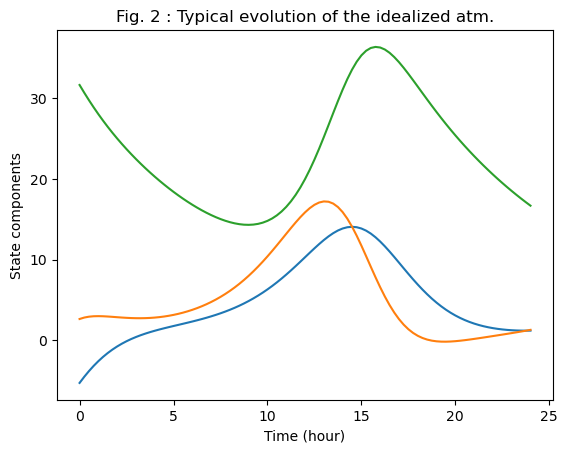

In [8]:
# Illustration of a typical idealized atmospheric time series
traj = nature.predict(window_24h, x0)

plt.plot(window_24h, traj)
plt.xlabel('Time (hour)')
plt.ylabel('State components')
plt.title(Fignum()+'Typical evolution of the idealized atm.');

In [9]:
# State of the atmosphere at 00UTC of day 1 of the year (January 1th at 00h UTC)
print("State of the atmosphere x0: ", x0)
# Wind magnitude at that time
print("Magnitude of the wind: ", nature.state2FF(x0))

State of the atmosphere x0:  [-5.31956275  2.6163562  31.67107832]
Magnitude of the wind:  0.44857548775739736


### **2.2 Wind speed observed along the idealized atmo. time evolution**

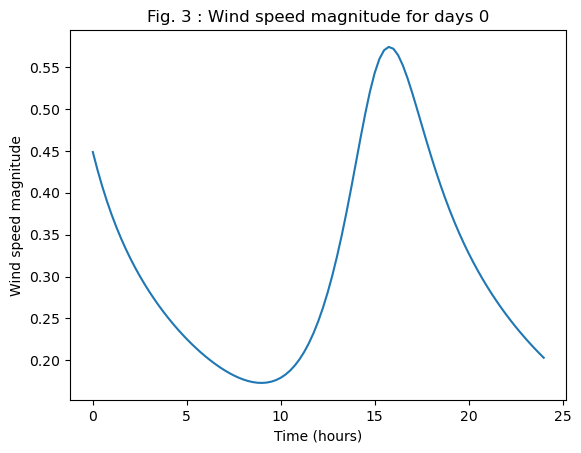

In [10]:
wind = lambda states_list : np.asarray([ nature.state2FF(state) for state in states_list])
plt.plot(window_24h, wind(traj))
plt.xlabel('Time (hours)')
plt.ylabel('Wind speed magnitude')
plt.title(Fignum()+"Wind speed magnitude for days 0");

### **2.3 Climate of the wind speed: A one year in the idealized world**

In [11]:
# Create a database of 1year of atmospheric evolution (climate)
nb_days = 33+365      # number of days in a year + one month for starting 
ndt = 24*4*nb_days # number of quarters of hour in a year
window_climate = np.arange(ndt)*nature.dt

In [12]:
climate_traj = nature.predict(window_climate, x0)

In [13]:
wind_climate = wind(climate_traj)

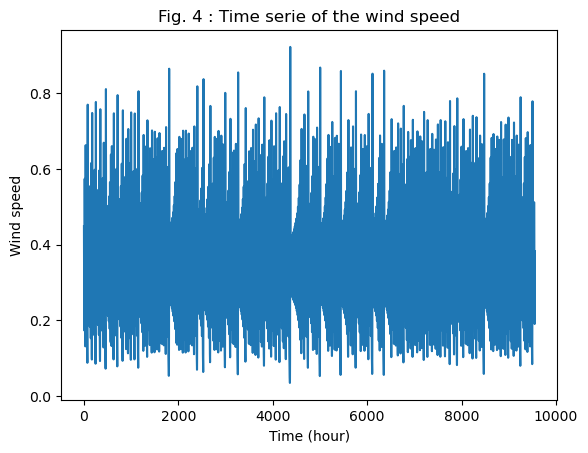

In [14]:
plt.plot(window_climate, wind_climate)
plt.xlabel('Time (hour)')
plt.ylabel("Wind speed")
plt.title(Fignum()+'Time serie of the wind speed');

**Some statistics for the wind speed**

In [15]:
wind_climate_mean = wind_climate.mean()
wind_climate_std = wind_climate.std()
print('Climate mean: ',wind_climate_mean)
print('Climate typical variation (standard deviation): ',wind_climate_std)
print('Minimum of observed wind: ',wind_climate.min())
print('Maximum of observed wind: ', wind_climate.max())

Climate mean:  0.3045700668460906
Climate typical variation (standard deviation):  0.14745782220708167
Minimum of observed wind:  0.03438398032065033
Maximum of observed wind:  0.9227638173945318


**Illustration of the wind speed climate**

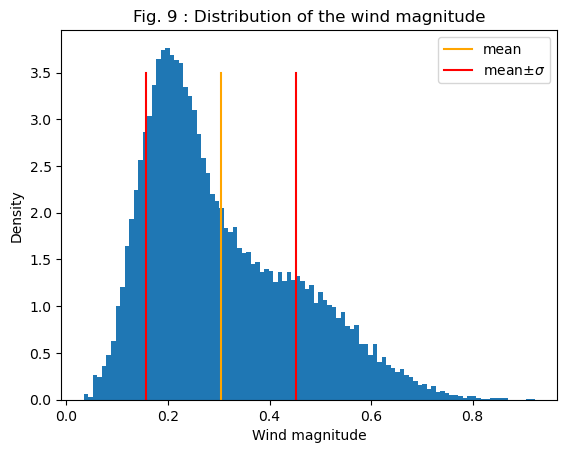

In [20]:
plt.hist(wind_climate,100, density=True);
plt.plot(2*[wind_climate_mean],[0,3.5],color='orange', label='mean')
plt.plot(2*[wind_climate_mean+wind_climate_std],[0,3.5],'r', label='mean$\pm \sigma$')
plt.plot(2*[wind_climate_mean-wind_climate_std],[0,3.5],'r')
plt.xlabel("Wind magnitude")
plt.ylabel("Density")
plt.legend()
plt.title(Fignum()+"Distribution of the wind magnitude");

<div style="margin:0 50px 0 50px">
<h4><b>Question: </b></h4>
<div style="background:MistyRose">

describe the density of the atmospheric wind in this idealized world

</div>
</div>

***Answer here***

<div style="margin:0 50px 0 50px">
<h4><b>Question: </b></h4>
<div style="background:MistyRose">
can you predict the wind speed of a day ahead when you don't know anything about the present weather situation ? What is the error of your prediction ? (in average) (indication: when you don't know anything, the best prediction is the climate mean)
</div>
</div>

***Answer here***

## **3. Wind power prediction**

A **wind power plant** contains several **wind turbines** that convert a part of the mecahnical energy of the wind into electricity.

The precise relation between the wind speed and the power production depends on several parameters: the technology used for the wind turbine, the topology of wind park, and of course the wind speed... But to protect the wind turbines from large wind  events, the production needs to stop when the wind speed is larger from a maximum treshold.

While all these is complex to model and represent fairly, it can be simplified as a **transfert function** e.g. from experimental data.

This transfert function gives the amount of power produced for a given level of wind speed. It can also be defined as a fraction of the maximal power production of a wind park.

Thereafter, the transfert function is denoted by `FF2PE` and gives the power production related to the wind speed. We do not considered 

In [21]:
from valeco import WindPowerPlant

In [22]:
powerplant = WindPowerPlant()

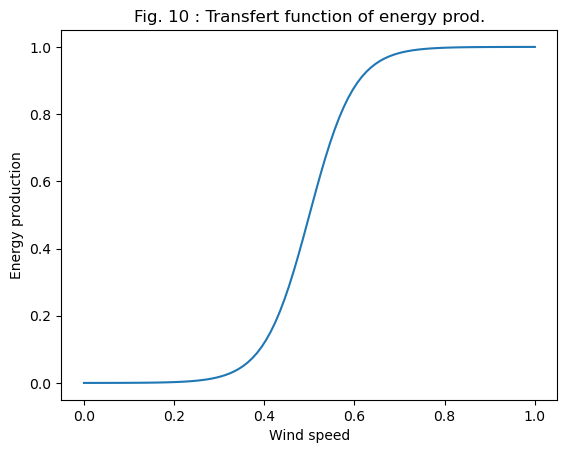

In [23]:
wind_speed = np.linspace(0.,1.,100)
plt.plot(wind_speed, [powerplant.FF2PE(FF) for FF in wind_speed] )
plt.xlabel("Wind speed")
plt.ylabel("Energy production")
plt.title(Fignum()+'Transfert function of energy prod.');
plt.savefig("./figures/fig-transfert-function-wind-power.png")

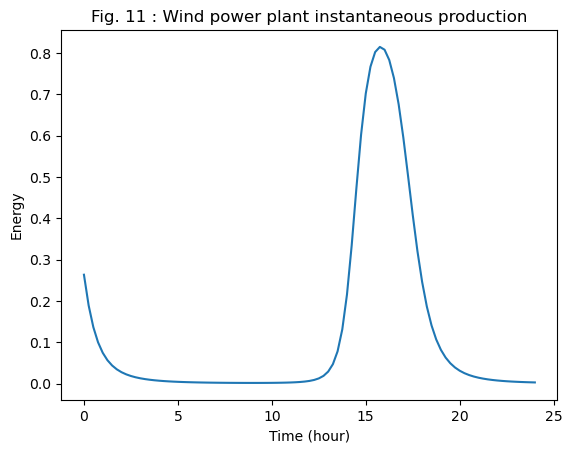

In [24]:
wind_power = lambda winds: np.asarray([ powerplant.FF2PE(FF) for FF in winds])

traj = nature.predict(window_24h, x0)

wind_power_observed = wind_power(wind(traj))

plt.plot(window_24h, wind_power_observed)
plt.xlabel('Time (hour)')
plt.ylabel('Energy')
plt.title(Fignum()+"Wind power plant instantaneous production");

<div style="margin:0 50px 0 50px">
<h4><b>Question: </b></h4>
<div style="background:MistyRose">
comment the wind production along the time. What can be the effect of such an intermitent renewable energy ?
</div>
</div>

***Answer here***

## **4. Real time prediction of the atmosphere**

There exists several way to predict the weather from a given weather situation:

 * The **climate prediction**: the prediction is given by the climate mean, and is constant over the forecast window.
 * The **persistence**: the prediction is given by the value of the weather observed at the initial time of the forecast window.
 * The numerical weather prediction: the prediction is obtained from the numerical integration of atmosphere dynamics, from a given initial condition that is so-called **analysis state** in the realm of **data assimilation**


**Definition of a predicting system that consits in an approximation of the true nature (with an additionnal error)**

In [123]:
f = 0.0 # model error / 0.01 / 
model = valeco.Nature(f=f)
x0a = x0+0.4*np.random.normal(size=3) # a prior state for the initial condition of the NWP forecast 

Here, the dynamics of the "numerical model" that would corresponds to the state-of-the-art numerical weather prediction in real application, is similar to the Nature except that a parameter is $f=0.01$ while for the nature it is $f=0.0$, so it mimics the realm of NWP. 

**Definitions of the different prediction system (climate, persistence and NWP)**

In [128]:
# Persistence model
dynamics = {
    'nature': nature,
    'NWP forecast': model,
    'persistence': valeco.Persistence(),
    'clim. pred.': valeco.Climate(climate_traj),
}

In [129]:
dynamics['clim. pred.']._mean

array([-0.2381354 , -0.24004774, 22.51442583])

### **4.1 About the interest to prediction the wind speed from a numerical model**

In this section we explore the interest different forecasting approach for a given date.

In [130]:
initial_states = {
    'nature': x0,
    'NWP forecast': x0a,
    'persistence': x0a,
    'clim. pred.': x0a,
}
color = {
    'nature': 'blue',
    'NWP forecast': 'orange',
    'persistence': 'green',
    'clim. pred.': 'red',    
}

In [131]:
wind_data = { 
    dynamic:wind(dynamics[dynamic].predict(window_24h, initial_states[dynamic])) for dynamic in dynamics
}
error_wind_data = { 
    dynamic:wind_data[dynamic] - wind_data['nature'] for dynamic in dynamics if dynamic != 'nature'
}

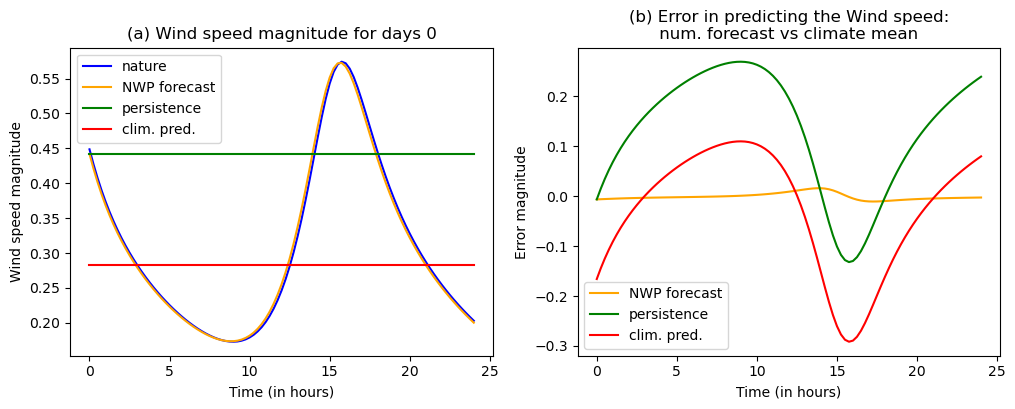

In [132]:
# Comparison of the wind speed prediction versus the observation
[fig, axes] = plt.subplots(1,2, figsize=(12,4))
ax1, ax2 = axes

for key, value in wind_data.items():
    ax1.plot(window_24h, value,label=key, color=color[key])
ax1.set_xlabel('Time (in hours)')
ax1.set_ylabel('Wind speed magnitude')
ax1.set_title('(a) Wind speed magnitude for days 0')
ax1.legend()

# Discepency between real wind speed and its differents predictions.
for key, value in error_wind_data.items():
    ax2.plot(window_24h, value,label=key, color=color[key])

ax2.set_xlabel('Time (in hours)')
ax2.set_ylabel('Error magnitude')
ax2.set_title('(b) Error in predicting the Wind speed:\n num. forecast vs climate mean ')
ax2.legend();

<div style="margin:0 50px 0 50px">
<h4><b>Question: </b></h4>
<div style="background:MistyRose">
<ol>
    <li>From panel (a), describe the wind of the nature and of the forecast for day 0, are they exaclty the same ?</li>
    <li>Is it interesting to forecast the wind speed from numerical weather prediction (compared with the climate mean and the persistence) ?
</li>
</ol>    
</div>
</div>

***Answer here***

### **4.2 Impact on the prediction of a wind park production**

Now we explore the impact of the forecast on the power prediction.

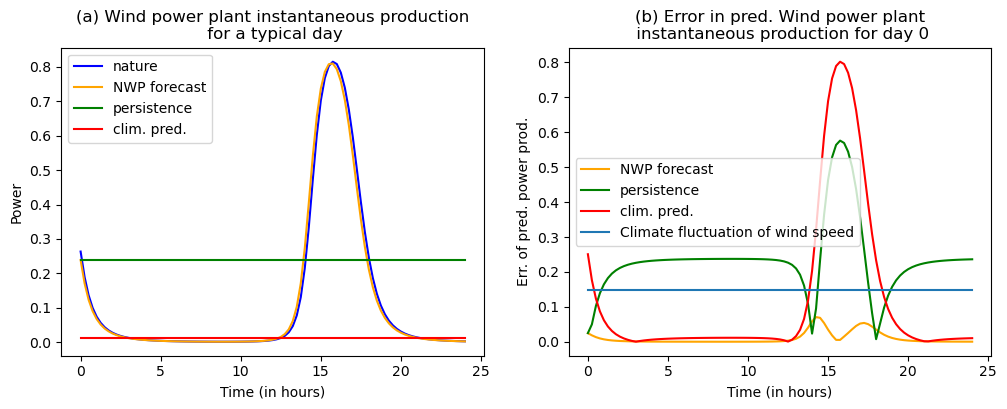

In [133]:
# Wind power prod. : real vs. predicted

wind_power_data = { dynamic: wind_power(wind_data[dynamic]) for dynamic in dynamics }

error_wind_power_data = { 
    dynamic:wind_power_data[dynamic] - wind_power_data['nature'] for dynamic in dynamics if dynamic != 'nature'
}

# Comparison of the wind speed prediction versus the observation
[fig, axes] = plt.subplots(1,2, figsize=(12,4))
ax1, ax2 = axes
for key, value in wind_power_data.items():
    ax1.plot(window_24h, value,label=key, color=color[key])
ax1.set_xlabel('Time (in hours)')
ax1.set_ylabel('Power')
ax1.set_title('(a) Wind power plant instantaneous production\n for a typical day')
ax1.legend()

# Discepency between real wind speed and its differents predictions.

for key, value in error_wind_power_data.items():
    ax2.plot(window_24h, np.abs(value),label=key, color=color[key])

ax2.plot([window_24h[k] for k in [0, -1]], 2*(wind_climate_std,),label='Climate fluctuation of wind speed')

ax2.set_xlabel('Time (in hours)')
ax2.set_ylabel('Err. of pred. power prod.')
ax2.set_title('(b) Error in pred. Wind power plant\n instantaneous production for day 0')
ax2.legend();

### **4.3 Impact on the prediction of a wind park total production**

**Comparison of total production along the day**

In [134]:
total_prod = {key: sum(value) for key,value in wind_power_data.items()}

In [135]:
total_prod

{'nature': 12.071068916053846,
 'NWP forecast': 11.921816260663737,
 'persistence': 23.15746848731309,
 'clim. pred.': 1.2387736876780058}

**Production observed along the climate**

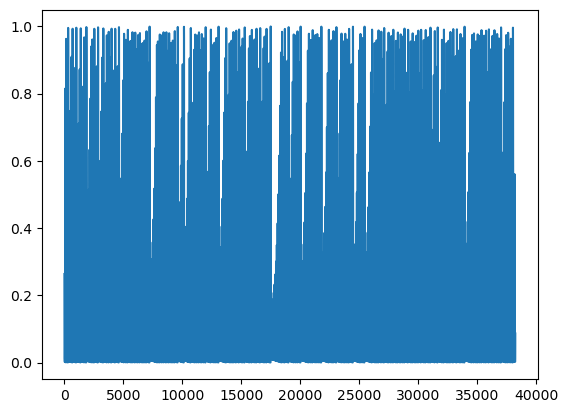

In [136]:
plt.plot(wind_power(wind(climate_traj)))

### **4.4 Impact of uncertainty on PE prediction**

This section illustrates what happends when the initial state is not perfectly known and when an ensemble is introduced so sample the futur.

In [137]:
Ne = 50
trajectories = {
    'nature': nature.predict(window_24h,x0),
    'NWP forecast' : model.predict(window_24h,x0a),
    'NWP ensemble for.' : model.ensemble_forecast(window_24h,(x0a+0.4*np.random.normal(size=3) for k in range(Ne))),
}
colors = {
    'nature': 'b--',
    'NWP forecast' : 'b',
    'NWP ensemble for.' : 'g',
}

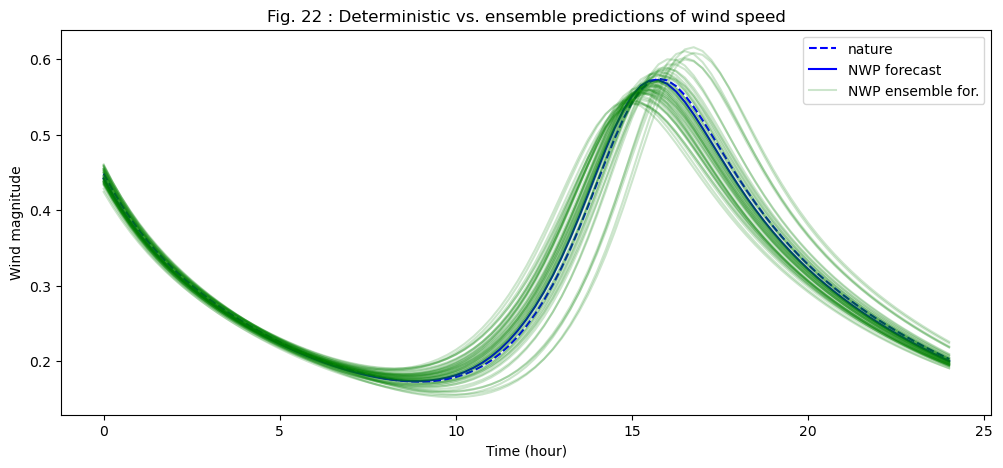

In [138]:
plt.figure(figsize=(12,5))
for name, traj in trajectories.items():
    if name!='NWP ensemble for.':
        #plt.plot(window_24h, traj[:,2], colors[name], label=name)
        plt.plot(window_24h, wind(traj), colors[name], label=name)
    else:
        for member in range(Ne):
            data = wind([traj[t][member] for t in window_24h])
            label = name if member==0 else None            
            plt.plot(window_24h, data, colors[name], alpha=0.2, label=label)

plt.xlabel('Time (hour)')
plt.ylabel('Wind magnitude')
plt.legend()
plt.title(Fignum()+"Deterministic vs. ensemble predictions of wind speed");
plt.savefig('./figures/fig-uncertainty-weather-forecast.png')

<div style="margin:0 50px 0 50px">
<h4><b>Question: </b></h4>
<div style="background:MistyRose">
Previous figure represents the time evolution of wind speed when predicted from a single forecast (blue) vs. an ensemble of forecasts (green), the observation (the nature) is the dashed blue line.
<ol>
    <li>What is the time evolution of the uncertainty here ?</li>
    <li>What is a phase shift error of prediction? </li>
    <li>What is the interest of ensemble prediction? </li>
</ol>    
</div>
</div>

***Answer here***

### **4.5 Assimilation cycle to built a data base for real time PE prediction**

#### **4.5.1 EnKF cycles**

In [226]:
#EnKF
nb_heating_cycles = 33
nb_cycles = (2*365)*4 + nb_heating_cycles

stdo = 0.8
xf = x0+0.3*np.random.normal(size=3)
Xf = [xf+0.3*np.random.normal(size=3) for k in range(Ne)]
analysis_error = []

H = np.eye(3)
R = stdo**2*H
xt = x0

assim_nature_db = [] # true state
assim_eps_db = []    # ensemble of forecasts
assim_obs_db = []    # ensemble of forecasts
assim_Xa_db = []
assim_xt_db = []

print("Compute assimilation cycles over a long period")

for k in valeco.range_bar(nb_cycles):
    #
    # Analysis state
    #
    # Build synthetic observations to mimic real observations of Nature
    yo = xt + stdo*np.random.normal(size=3)
    
    # Estimate the covariance matrix    
    ef = (np.asarray(Xf) - np.asarray(Xf).mean(axis=0)).T
    Pf = 1/Ne* ef@ef.T
    # Compute Kalman's gain matrix K
    Ke = Pf@H.T@np.linalg.inv(H@Pf@H.T+R)
    # Assimilate base on error perturbation
    def assim(xf, yo):
        d = yo.T - H@xf.T
        xa = xf.T+Ke@d
        return xa.T
    
    perturbed_obs_gen = (yo+stdo*np.random.normal(size=3) for k in range(Ne))
    
    Xa = []
    for xf,yop in zip(Xf, perturbed_obs_gen):
        Xa.append(assim(xf, yop))
        
    
    #
    # Forecast step
    #
    xft = nature.predict(window_6h, xt)[-1]
    
    ens_traj = model.ensemble_forecast(window_6h, Xa)    
    Xf = ens_traj[window_6h[-1]]
    
    
    #
    # Built data base after a heating period of 33 cycles.
    #
    if k>nb_heating_cycles:
        assim_obs_db.append(yo)
        assim_xt_db.append(xt)
        assim_Xa_db.append(Xa)
        
        analysis_error.append(np.linalg.norm(np.asmatrix(Xa).mean(axis=0)-xt))        
        
        assim_nature_db.append(xft)    # True state 
        assim_eps_db.append(Xf)        # EPS prediction of the true state xft.
        
    xt = xft
        
    
        
    
    

Compute assimilation cycles over a long period


IntProgress(value=0, description='Loading:', max=2953)



#### **4.5.2 Validation data assimilation**

**Magnitude of the analysis error along the time**

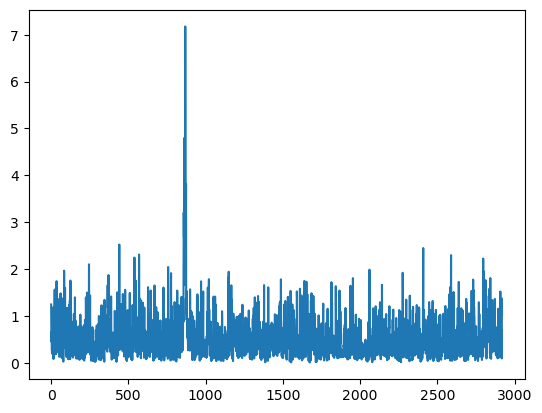

In [140]:
plt.plot(analysis_error)

**Exploration of the worse analysis case (divergence of the KF filter can occur)**

worse case:  868


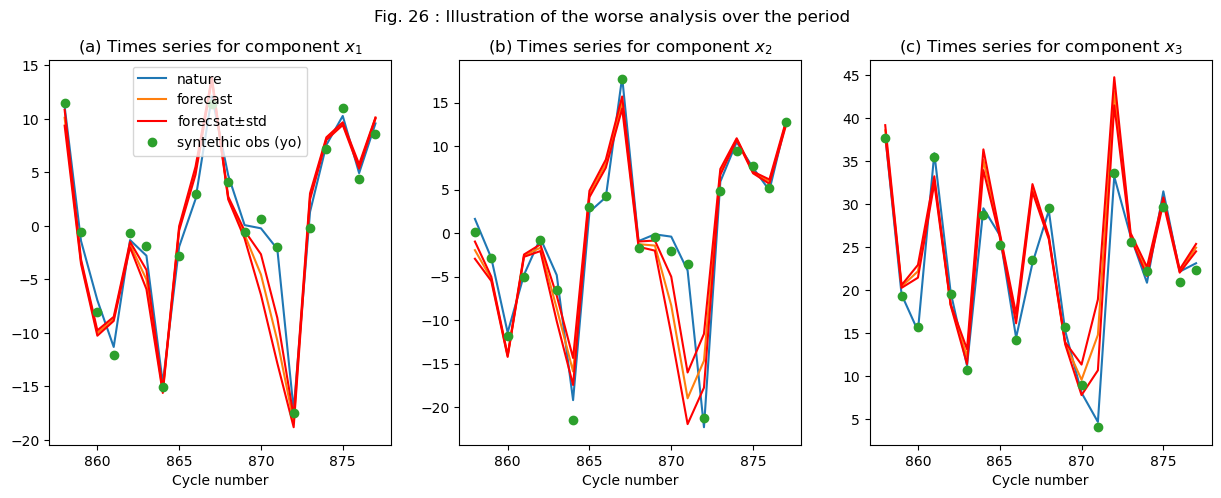

In [153]:
# Illustration of situations of large uncertainty prediction

argmax_std = np.argmax(analysis_error)
print('worse case: ',argmax_std)

plt.figure(figsize=(15,5))
start_sample = argmax_std-10
end_sample = argmax_std+10
for k,panel in zip(range(3),'abc'):
    plt.subplot(131+k)
    # Nature
    plt.plot(range(start_sample,end_sample),[state[k] for state in assim_nature_db[start_sample:end_sample]],label='nature')
    # Forecast + uncertainty
    plt.plot(range(start_sample,end_sample),[state[k] for state in forecasts[start_sample:end_sample]],label='forecast')
    plt.plot(range(start_sample,end_sample),[state[k]+std[k] for state,std in zip(forecasts[start_sample:end_sample],std_forecasts[start_sample:end_sample])],'r',label='forecsat$\pm$std')
    plt.plot(range(start_sample,end_sample),[state[k]-std[k] for state,std in zip(forecasts[start_sample:end_sample],std_forecasts[start_sample:end_sample])],'r')
    # Observation
    plt.plot(range(start_sample,end_sample),[obs[k] for obs in assim_obs_db[start_sample+1:end_sample+1]], 'o',label='syntethic obs (yo)',)
    plt.xlabel('Cycle number')
    if k==0:
        plt.legend()
    plt.title(f'({panel}) '+'Times series for component $x_{'+str(k+1)+'}$')
plt.suptitle(Fignum()+'Illustration of the worse analysis over the period');

**Magnitude of the forecast error standard-deviation computed from the ensemble along the time**

In [150]:
# Exploration de la prévision déterministe déduite de l'ensemble
forecasts = [np.mean(ens,axis=0) for ens in assim_eps_db]
std_forecasts = np.asarray([np.std(ens,axis=0) for ens in assim_eps_db])

So to evaluate the uncertainty prediction we can compute a diagnosis of the total uncertainty. For instance, the averaged std given as 
$$\sigma_\textrm{tot.} = \sqrt{\frac{1}{n}\sum_j \sigma(x_j)^2},$$
where $\sigma(x_j)$ denotes the standard-deviation of the forecast error of the $j^\textrm{th}$ component of the state vector $\mathbf{x}=(x_1,x_2,x_3)$.

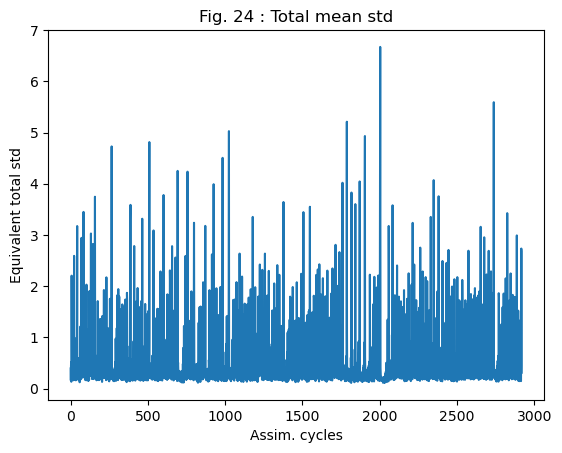

In [151]:
total_std_forecasts = np.sqrt((std_forecasts**2).mean(axis=1))
plt.plot(total_std_forecasts)
plt.xlabel('Assim. cycles')
plt.ylabel('Equivalent total std')
plt.title(Fignum()+'Total mean std');

**Assimilation cycles of largest uncertainty**

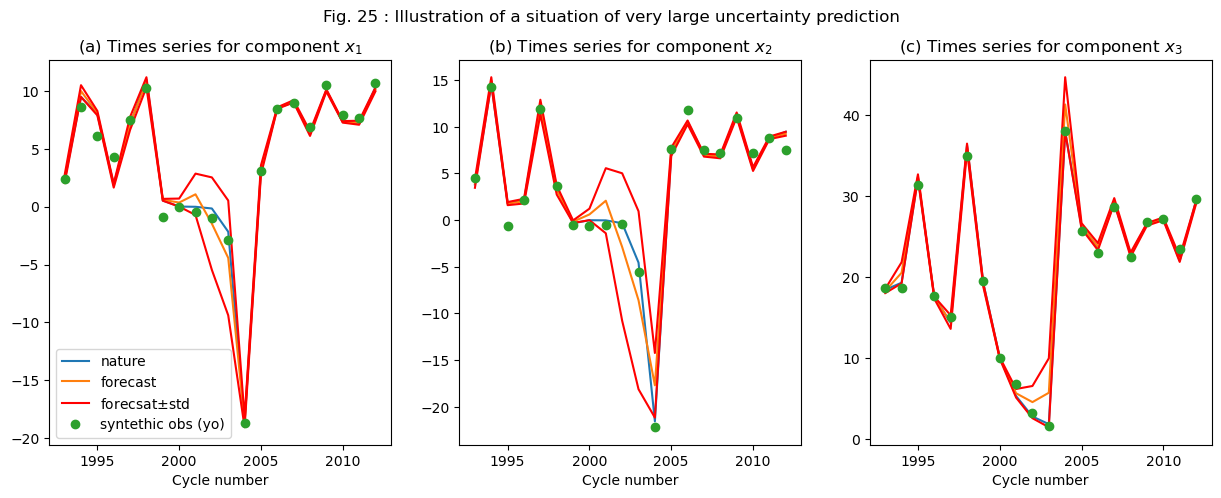

In [152]:
# Illustration of situations of large uncertainty prediction

argmax_std = total_std_forecasts.argmax()

plt.figure(figsize=(15,5))
start_sample = argmax_std-10
end_sample = argmax_std+10
for k,panel in zip(range(3),'abc'):
    plt.subplot(131+k)
    # Nature
    plt.plot(range(start_sample,end_sample),[state[k] for state in assim_nature_db[start_sample:end_sample]],label='nature')
    # Forecast + uncertainty
    plt.plot(range(start_sample,end_sample),[state[k] for state in forecasts[start_sample:end_sample]],label='forecast')
    plt.plot(range(start_sample,end_sample),[state[k]+std[k] for state,std in zip(forecasts[start_sample:end_sample],std_forecasts[start_sample:end_sample])],'r',label='forecsat$\pm$std')
    plt.plot(range(start_sample,end_sample),[state[k]-std[k] for state,std in zip(forecasts[start_sample:end_sample],std_forecasts[start_sample:end_sample])],'r')
    # Observation
    plt.plot(range(start_sample,end_sample),[obs[k] for obs in assim_obs_db[start_sample+1:end_sample+1]], 'o',label='syntethic obs (yo)',)
    plt.xlabel('Cycle number')
    if k==0:
        plt.legend()
    plt.title(f'({panel}) '+'Times series for component $x_{'+str(k+1)+'}$')
plt.suptitle(Fignum()+'Illustration of a situation of very large uncertainty prediction');

<div style="margin:0 50px 0 50px">
<h4><b>Question: </b></h4>
<div style="background:MistyRose">
Comment the previous times series that show the evolution of the nature, its observation, and the ensemble of forecast (mean +/- std).
</div>
</div>

***Answer here***

#### **4.5.3 Built data base for PE prediction**

**Compute the data base for instantaneous or total production**

In [154]:
# Computation of the total PE 24h ahead or instantaneous PE 6h ahead
total_PE = False
if total_PE:
    # Computation of the total PE production predicted 24h ahead vs. observed.
    PEt = []
    PEeps = []
    PEf = [] # computed from the mean ensemble state.
    for k in valeco.range_bar(nb_cycles):
        # Ensemble predictions        
        traj = model.ensemble_forecast(window_24h,assim_Xa_db[k])
        
        # Computation of the total production predicted a day ahead
        # 1. Ensemble of forecast
        predicted_total_PEs = np.zeros(Ne)
        for t in window_24h:
            predicted_total_PEs += wind_power(wind(traj[t]))

        PEeps.append(predicted_total_PEs)
        
        # 2. Computation for the ensemble mean Xf mean (ensemble)
        ensemble_mean = [np.asarray(traj[t]).mean(axis=0) for t in window_24h]
        FFf = wind(ensemble_mean)
        PEf = wind_power(wind(ensemble_mean))
        


        # Observed true production
        observed_total_PE = sum(wind_power(wind(nature.predict(window_24h, assim_nature_db[k]))))
        PEt.append(observed_total_PE)
else:
    PEt = wind_power(wind(assim_nature_db))
    PEeps = [wind_power(wind(Xf)) for Xf in assim_eps_db]
    PEf = [wind_power(wind([np.asarray(Xf).mean(axis=0)])) for Xf in assim_eps_db]
    FFf = [wind([np.asarray(Xf).mean(axis=0)]) for Xf in assim_eps_db]
    FFeps = [wind(Xf) for Xf in assim_eps_db]

**Exploration of the observed vs. predicted production**

In [155]:
def plot_predic_vs_true(PEt, PEf, ax):    

    try:
        Ne = len(PEf[0])        
    except:
        Ne = 1
        
    if Ne>1:
        data_PEt = []
        data_PEf = []        
        for pet, pef in zip(PEt, PEf):            
            data_PEf += [pe for pe in pef]
            data_PEt += Ne*[pet]
    else:
        data_PEf = PEf
        data_PEt = PEt
            
    ax.plot(data_PEf, data_PEt,'k.')


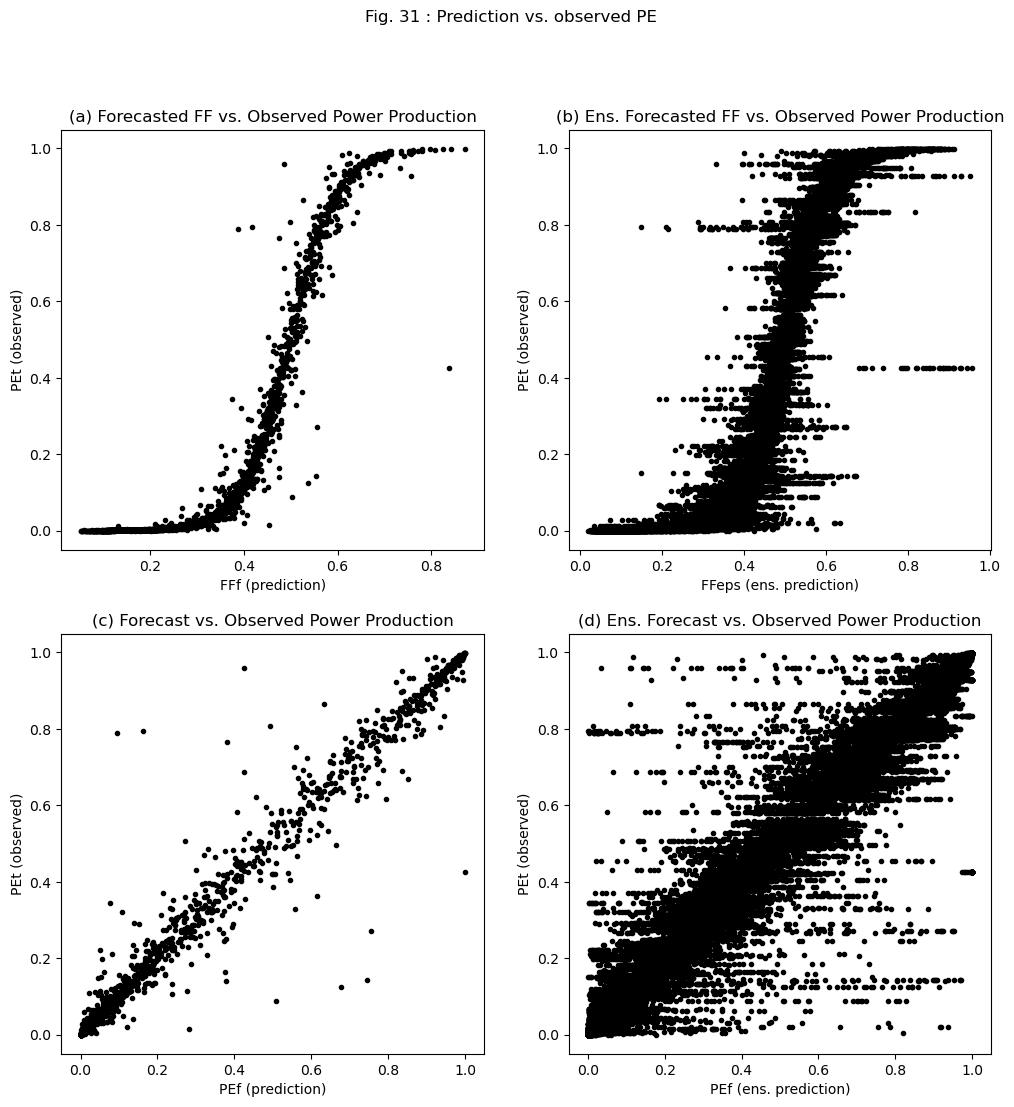

In [203]:
fig, AX = plt.subplots(2,2,figsize=(12,12))

AX = AX.flatten()

ax = AX[0]
plot_predic_vs_true(PEt, FFf, ax)
ax.set_title('(a) Forecasted FF vs. Observed Power Production')
ax.set_xlabel('FFf (prediction)')
ax.set_ylabel('PEt (observed)')    

ax = AX[1]
plot_predic_vs_true(PEt, FFeps, ax)
ax.set_title('(b) Ens. Forecasted FF vs. Observed Power Production')
ax.set_xlabel('FFeps (ens. prediction)')
ax.set_ylabel('PEt (observed)')    

ax = AX[2]
plot_predic_vs_true(PEt, PEf,ax)
ax.set_title('(c) Forecast vs. Observed Power Production')
ax.set_xlabel('PEf (prediction)')
ax.set_ylabel('PEt (observed)')    

ax = AX[3]
plot_predic_vs_true(PEt,PEeps, ax)
ax.set_title('(d) Ens. Forecast vs. Observed Power Production')
ax.set_xlabel('PEf (ens. prediction)')
ax.set_ylabel('PEt (observed)')    

plt.suptitle(Fignum()+"Prediction vs. observed PE");

**Losses due to the error of prediction**

In [157]:
# Computation of the loss in case where the prediction is used as the contract 
loss(PEf[0], PEt[0])

array([0.0192103])

In [158]:
losses = [loss(pef, pe) for pef, pe in zip(PEf, PEt)]

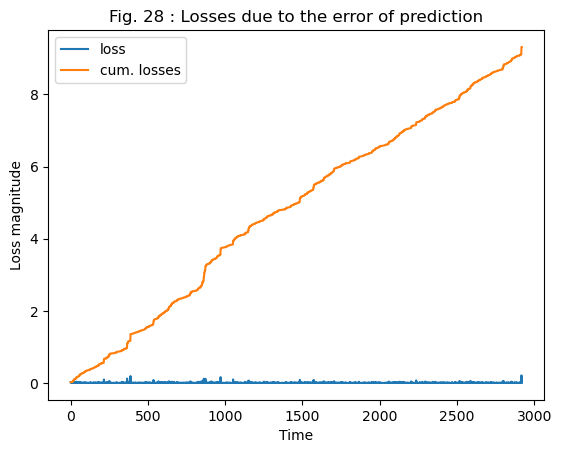

In [159]:
plt.plot(losses, label='loss')
plt.plot(np.cumsum(losses), label='cum. losses')
plt.legend()
plt.title(Fignum()+"Losses due to the error of prediction")
plt.xlabel("Time")
plt.ylabel("Loss magnitude");

## **5. Optimization of the contract PE: $PE_c$**

As seen in the previous section, a bad estimation of $PE_c$ can leads to losses. 

How to specify the production in the contract ? so to reduce the losses ?

$$L(PE_c, PE) = k_1 (PE-PE_c)^+ + k_2 (PE_c-PE)^+.$$

Different strategies can be introduced depending on the amount of informations that are available. Here three kind of information can be introduced:
- the climate, 
- the forecast, 
- the ensemble of forecasts.

which leads to three different strategies for setting the best PE to prescribes in the contract of the producer, $PE_c^*$ .

### **5.1 Details of the strategies**

**1) Best $PE_c$ from past observation of PE (climate of PE)**

If no information is available, than the value of $PE_c$ can be deduced from the observed typical values of $PE$ so to minimise the losses.

In particular, if we observed $(PE_i)_{i\in Clim.}$, a prior loss associated witth a value of $PE_c$ is given by
$$\widehat{L}_\mathrm{clim.}(PE_c)=\frac{1}{\#Clim.}\sum_{i\in Clim.} L(PE_c,PE_i),$$
where $\#\cdot$ stands for the cardinality operator which return the size of an ensemble. 
We recognize here the expectation of the loss over the climate data, 
$$\widehat{L}_\mathrm{clim.}(PE_c)=\mathbb{E}_{PE} [L(PE_c,PE)],$$

Hence, the best $PE_c^*$ value of $PE_c$ would be such that it mimize this averaged loss, that is 
$$PE_c^* = \textrm{ArgMin}_{PE_c} \mathbb{E}_{PE} [L(PE_c,PE)].$$

Note that because $\widehat{L}_\mathrm{clim.}(PE_c)$ is not linear (since $L$ is not linear), then the best value $PE_c^*$ may be different from $\mathbb{E}[PE]\equiv \frac{1}{\#Clim.}\sum_{i\in Clim.} PE_i$.

**2) Best $PE_c$ from prediction system ($PE_f$)**

If a prediction $PE_f$ of $PE$ is available, since it provides a valuable information compared with climate (constant) prediction, it should be able to obtain a better proposal for $PE_c^*$ so to minimizes the losses.

In spite of the quality of the forecasts, the forecast error induces a loss, but this time the loss depends on the forecast value. By adapting the a priori climatologial loss, the loss expected for a givent prediction reads as  
$$\widehat{L}_f(PE_c, PE_f)=\mathbb{E}_{PE} [L(PE_c,PE)/PEf],$$
or
$$\widehat{L}_f(PE_c,PE_f)=\int_{PE} L(PE_c,PE) p(PE/PEf) dPE.$$
where $p(PE/PEf)$ denotes the conditionnal density of observed $PE$ for a given prediction $PE_f$.

To evaluate this loss, we need to determine the conditionnal density $p(PE,PE_f)$, which can be deduced from the past statitics of prediction Fig. 11

Then the optimal value reads as 
$$PE_c^* = \textrm{ArgMin}_{PE_c} \mathbb{E}_{PE} [L(PE_c,PE)/PEf].$$

**3) Best $PE_c$ from ensemble prediction system ($PE_\textrm{eps.}$)**

Now, when an ensemble of prediction is known, the prior loss that account from  this information can be written as 
$$\widehat{L}_\textrm{eps.} (PE_c, PE_\textrm{eps.})=\mathbb{E}_{PE_f}\left[\mathbb{E}_{PE} [L(PE_c,PE)/PEf]\right].$$

When the distribution of $PE_f$ is known from an ensemble of forecasts $PE_\textrm{eps.}=(PE_{f_k})_{k\in[1,N_e]}$, the empirical mean is used for the computation of the expectation $\mathbb{E}_{PE_f}$, so that
$$\widehat{L}_\textrm{eps.} (PE_c, PE_\textrm{eps.})=\frac{1}{Ne}\sum_{k\in[1,N_e]} \mathbb{E}_{PE} [L(PE_c,PE)/PEf_k].$$


### **5.2 Optimization strategies for $\widehat{L}$**

**Random walk exploration (simulated annealing)**

In [160]:
def simulated_annealing(l, seed, magnitude = 0.01):
    """ solve ArgMin l(x) starting from x=seed following a metaheuristic strategy """    
    k=0
    while k<1000:        
        l_seed = l(seed)
        if k%20==0:
            magnitude /= 2
        explore = seed + magnitude*np.random.normal()
        
        l_explore = l(explore)
        
        if l_explore<l_seed:
            #print(k, seed, explore, l_seed, l_explore )
            seed = explore
            
        k+=1
    return seed

**Newton's iterations for solving $\widehat{L}'(PEc)=0$**

If  $\widehat{L}(PE_c)$ is smooth enough, a better algorithm to find the optimal value $PE_c^*$ 
$$PE_c^* = \textrm{ArgMin}_{PE_c} \widehat{L}(PE_c),$$
is the solution of $$\frac{d\widehat{L}}{dPE_c}(PE_c)=0,$$
that can be solved from Newton's iterations.

Remind that Newton's iterations are introduced to solve a problem as $F(x)=0$, whose an approximation of the solution is deduced from the sequence 
$$x_{q+1} = x_q - \frac{F(x_q)}{F'(x_q)}.$$

In [161]:
def derivative(F, h=1e-5):    
    return lambda x: (F(x+h)-F(x-h))/(2*h)

In [162]:
def newtons_iterations(F, seed, tol=1e-10, max_iter = 20):
    """ Compute Newton's iteration from formal/numerical evaluation of dF 
    :param: F : a scalar function
    :return: state : value of F so that F(state)\approx 0
    """
    dF = derivative(F)
    state = seed
    for k in range(max_iter):
        state = state - F(state)/dF(state)
        if np.linalg.norm(F(state))<tol:
            print(f"Convergence is achieved after {k} iterations")
            break
    return state

An important requirement for Newton's iteration is to provide a starting point (seed) that is closed to the state we find. 

### **5.3 Abstract strategy**

**Definition of strategies**

So to compare the different strategies, we introduce an abstract (generic) classe for the experimental testbed

In [163]:
class PEcStrategy(object):
    """ Abstract class for a PEc strategy """
           
    optimizers = ['newton', 'simulated_annealing','argmin']    
    
    def __init__(self, *args, optim='newton',**kwargs):
        self._optimizer = optim
        
    def hat_loss(self, pec):
        """ Loss function to optimize """
        raise NotImplementedError
        
    def set_weather_information(self, *args, **kwargs):
        """ Set weather information """
        pass
    
    def plot_hat_loss(self):
        """ Plot of the loss function for a given weather situation """
        pec = np.linspace(0,1,200)
        plt.plot(pec,[self.hat_loss(p) for p in pec])
        plt.xlabel("PEc")
        plt.title('Loss $\widehat{L}(PE_c)$ depending on the information content')

    def get_seed(self):
        """ Get seed from simple computation to improve the PEc^* value"""
        PEc = np.linspace(0,1,50)
        idx = np.array([self.hat_loss(pec) for pec in PEc]).argmin()
        return PEc[idx]
        
    def get_pec(self, seed=None):
        """ Gest the optimal value 
        
        description
        -----------
        
        The optimal value is found for  $dL(PEC)/dPEC = 0$ where $L$ is the loss function to optimize
        
        This is solved considering Newton's iteration method.
        
        """        
        
        assert self._optimizer in self.optimizers
        
        if self._optimizer in ['newton', 'simulating_annealing']:
            if seed is None:
                seed = self.get_seed()
        
        if self._optimizer == 'newton':                        
            return newtons_iterations(derivative(self.hat_loss), seed)
        elif self._optimizer == 'simulated_annealing':
            return simulated_annealing(self.hat_loss, seed)
        else:
            PEc = np.linspace(0,1,200)
            idx = np.array([self.hat_loss(pec) for pec in PEc]).argmin()
            return PEc[idx]


In [164]:
strategies = {} # dictionnary of strategies.

## **6. Implementation of the strategies**

### **6.0 Observed $PE$ production from the past (climate of $PE$)**

In [165]:
# Computation of the optimal value of $PE_c$ so to minimize the losses
# Computation of the climate of PE
climate_PE = wind_power(wind_climate)

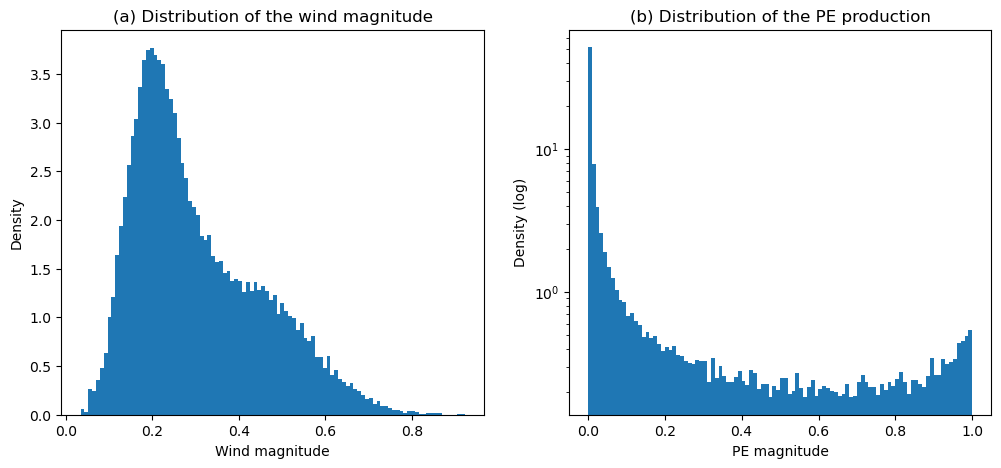

In [166]:
plt.figure(figsize=(12,5))
plt.hist(climate_PE,100)
plt.subplot(121)
plt.hist(wind_climate,100, density=True);
plt.xlabel("Wind magnitude")
plt.ylabel("Density")
plt.title("(a) Distribution of the wind magnitude");

plt.subplot(122)
plt.hist(climate_PE,100, density=True, log=True);
plt.xlabel("PE magnitude")
plt.ylabel("Density (log)")
plt.title("(b) Distribution of the PE production");

**Mean PE form the past as a proxy for PEc (when no assymetric loss)**

In [167]:
# Mean production observed from the past
mean_PE = climate_PE.mean()
print("Mean PE observed from the past: ", mean_PE)

Mean PE observed from the past:  0.14460822578463367


### **6.1 Best $PE_c$ from past observation of PE: $\widehat{L}_\mathrm{clim.}(PE_c)=\mathbb{E}_{PE} [L(PE_c,PE)]$**

For this strategy to specfy $PE_c^*$, the value of $PE_c^*$ is stationnary *i.e.* it is constant in time, and to speficy from the past observed value of $PE$ (the climate). 

Note that it would be possible to specity $PE_c^*$ from the wind strength, but since we introduced a transfert function, that mapps the wind into power production of energy, the problem remains the same.


**Compuation of the mean loss from climate database**

Here we compute the climatological mean loss 
$$\widehat{L}_\mathrm{clim.}(PE_c)=\mathbb{E}_{PE} [L(PE_c,PE)],$$
that is estimated from the climate database as 
$$\widehat{L}_\mathrm{clim.}(PE_c)=\frac{1}{\#Clim.}\sum_{i\in Clim.} L(PE_c,PE_i).$$




In [168]:
class ClimatePEcStrategy(PEcStrategy):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._seed = 0.01
        self._pec_star = None
    
    def hat_loss(self, pec):
        """ Average loss over the climate for PEc given: $\mathbb{E}_PE[L(PEc,PE)]$ """
        return loss(pec, climate_PE).mean()
    
    def get_pec(self):
        if self._pec_star is None:
            # Compute the constant PEc^* which is independent from the weather situation.
            self._pec_star = super().get_pec()
        return self._pec_star

In [169]:
strategies['climate'] = ClimatePEcStrategy()

**Evaluation of the prior loss when $PE_c=\mathbb{E}_\textrm{clim.}[PE]$**

In [170]:
# Average loss if PEc == mean(PE):
hat_loss = strategies['climate'].hat_loss
print("Average loss if PEc == mean(PE): ", hat_loss(mean_PE))

Average loss if PEc == mean(PE):  0.04870097840403629


**Average loss as a function of PEc**

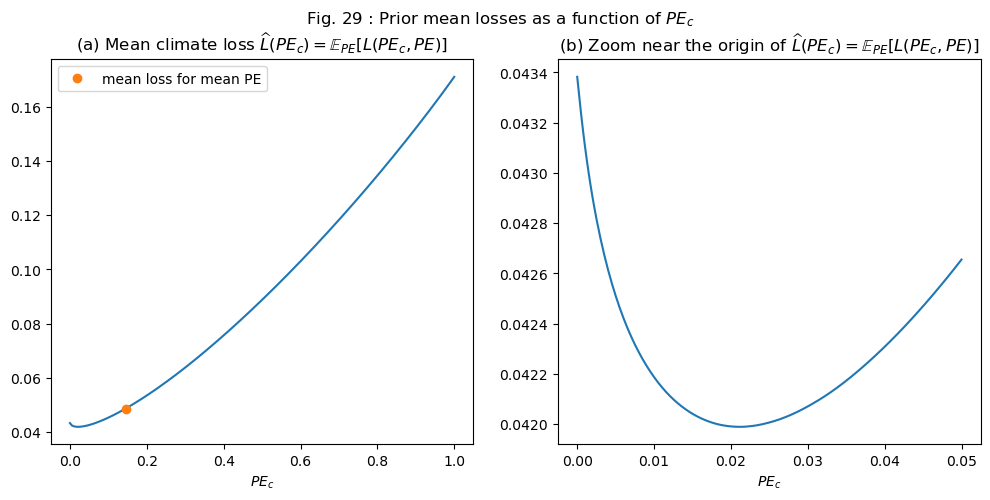

In [171]:

plt.figure(figsize=(12,5))
plt.subplot(121)
PEs = np.linspace(0, max(climate_PE),200)
plt.plot(PEs, [hat_loss(pe) for pe in PEs])
plt.plot(mean_PE, hat_loss(mean_PE),'o', label='mean loss for mean PE')
plt.xlabel("$PE_c$")
plt.legend()
plt.title("(a) Mean climate loss $\widehat{L}(PE_c)=\mathbb{E}_{PE} [L(PE_c,PE)]$")

plt.subplot(122)
PEs = np.linspace(0, 0.05,200)
plt.plot(PEs, [hat_loss(pe) for pe in PEs])
plt.xlabel("$PE_c$")
plt.title("(b) Zoom near the origin of $\widehat{L}(PE_c)=\mathbb{E}_{PE} [L(PE_c,PE)]$");
plt.suptitle(Fignum()+"Prior mean losses as a function of $PE_c$");

<div style="margin:0 50px 0 50px">
<h4><b>Question: </b></h4>
<div style="background:MistyRose">
<ol>
    <li>What is an estimatation of $PE_c^*$ the best value of $PE_c$ that minimize the loss in average from climate data</li>
    <li>Compared of the mean loss when $PE_c=\mathbb{E}[PE]$  </li>
    <li>Why $PE_c^*$ is different from $\mathbb{E}[PE]$? </li>
</ol>    
</div>
</div>

***Answer here from the information provided in the following cells***

In [232]:
# Computation of the optimal value of PEc^* 
strategies['climate'].get_pec()

0.021149788483369507

In [173]:
# Comparison with the mean(PE)
hat_loss = strategies['climate'].hat_loss
print("Average loss if PEc == mean(PE): ", hat_loss(mean_PE))
print("Average loss if PEc == PEc^*   : ", hat_loss(strategies['climate'].get_pec()))

Average loss if PEc == mean(PE):  0.04870097840403629
Average loss if PEc == PEc^*   :  0.041989701771845904


### **6.2 Best $PE_c$ from prediction system, $\widehat{L}_f(PE_c, PE_f)=\mathbb{E}_{PE} [L(PE_c,PE)/PEf]$**

Recap that in the case where a prediction is available (from a NWP system), the computation of the prior loss is given by
  
$$\widehat{L}_f(PE_c, PE_f)=\mathbb{E}_{PE} [L(PE_c,PE)/PEf],$$
or
$$\widehat{L}_f(PE_c,PE_f)=\int_{PE} L(PE_c,PE) p(PE/PEf) dPE.$$
where $p(PE/PEf)$ denotes the conditionnal density of observed $PE$ for a given prediction $PE_f$.

Then, the optimal contract PE is then solution of 
$$PE_c^* = \textrm{ArgMin}_{PE_c}\mathbb{E}_{PE} [L(PE_c,PE)/PEf] = \textrm{ArgMin}_{PE_c}\widehat{L}_f(PE_c, PE_f).$$

So we have to compute the conditionnal density $p(PE/PEf)$. 

**From the empirical probability to conditional probability**

However, the density is not know directly since we only know samples of the distribution.

In particular, the joint-probability distribution of $(PEf,PE_t)$ is only known from its empirical approximations that is 
$$\mathbb{P}_{(PEf,PE)}=\frac{1}{\# Clim.}\sum_{i\in Clim.} \frac{1}{N_e}\sum_{k\in [1,N_e]} \delta_{(PE^f_{i,k}, PE_i)},$$
where $\delta$ stands for the Diract distribution *i.e.* such that $\int_\mathbb{R} f(x)\delta(dx) = f(0)$.


Then, the conditionnal probability reads as 
$$\mathbb{P}_{PE/PE_f\in dPE_f}=\frac{1}{\# Clim.}\sum_{i\in Clim.} \frac{1}{N_e}\sum_{k\in [1,N_e]} \delta_{(PE^f_{i,k}, PE_i)} \chi_{dPE_f}(PE^f_{i,k}),$$
where $\chi_X(x)= 1$ ($=0$) if $x\in X$ ($x\notin X$)

**Estimation of the density**

Moreoever, because of the finite size of the data base, the latter distribution has no density function of probability, while we use to have one. To overcome this issue, a [**kernel desnsity estimate (kernel dressing)**](https://en.wikipedia.org/wiki/Kernel_(statistics)) is considered which remains to replace Dirac distributions by probability with density function, for instance by using a Gaussian distribution, or an **Epanechnikov's compact supported kernel function** that reads as 
$$K(u)=\frac{3}{4}(1-u^2)\text{ for $|u|\leq 1$ ($0$ elsehere)},$$
such that $\int_\mathbb{R} K(u)du = 1$ ($K$ is a density of probability), 
and its normalized rescaled versions $K_h(u) = \frac{1}{h} K(\frac{1}{h} u)$ for $h>0$ which vanishes for $|u|>h$.

Hence, it results that the estimated conditional density function reads as 
$$p_{PE/PEf}(pe) dPEf=\frac{1}{\# Clim.}\sum_{i\in Clim.} \frac{1}{N_e}\sum_{k\in [1,N_e]} K_h\left( pe-PE_{i}\right)\chi_{dPE_f}(PE^f_{i,k}),$$

In [174]:
from sklearn.neighbors import KernelDensity

In [175]:
class ConditionnalDistribution(object):
    """ Computation of p(PE/PEf) from samples (PE_i,PEf_i) 
    
    
    the conditional distribution is performed from a set of bins [0,h]
    
    
    """
    def __init__(self, PE, PEeps, nbins_PEf=200, bandwidth=0.05):
        """ (PE, PEeps)
        PEeps : ensemble of forecast leading to a PE
        PE    : PE observed
        
        From numerical test, the optimal bandwith is obtained for thereabout $h\approx 0.06$
        """        
        
        # build data base of PE to create the data base (PE_i,PE_i,k)_{i,k} indexed by (i,k)
        Ne = PEeps.shape[1]
        
        tmp = np.zeros(PEeps.shape)
        for k in range(Ne):
            tmp[:,k] = PE
            
        self._PE = tmp.flatten()
        self._PEf = PEeps.flatten()        
        
        # Computation of the bins of PEf
        self._bins = np.linspace(0,1,nbins_PEf+1)
        # centers of bins
        self.bin_centers = 0.5*(self._bins[1:]+self._bins[:-1])
        self.bin_resolution = self._bins[1]/2
        
        self._conditional_distributions = {}
        
        for bin_center in self.bin_centers:
            # 1. select the PEf near to the bin center
            # .. todo 
            bin_selection = self._distance_to_bin(self._PEf, bin_center)<self.bin_resolution
            
            # 2. compute the kernel density of the selected database
            self._conditional_distributions[bin_center] = KernelDensity(kernel="epanechnikov", 
                                                            bandwidth=bandwidth).fit(np.expand_dims(self._PE[bin_selection],axis=1))        
            
        self.set_discretized_conditional_distribution()
        
    def _distance_to_bin(self, PEf, bin_center):
        return np.abs(PEf-bin_center)
    
    def _nearest_bins_index(self, PEf):
        return np.abs(PEf-self.bin_centers).argmin()
    
    def _nearest_bins(self, PEf):
        return self.bin_centers[self._nearest_bins_index(PEf)]
    
        
    def set_discretized_conditional_distribution(self, n=200):
        self._pe = np.linspace(0,1,n) # discretization of pe
        
        # Compute the discretized distrbution -- they ar not normlized
        # 1. Compute the un-normlized density
        self._discretized_cond_distribs = {
            bin_center : np.exp(kde.score_samples(np.expand_dims(self._pe,axis=1)))
            for bin_center,kde in self._conditional_distributions.items() 
        }
        
        # 2. Normalize the densities
        one_func = lambda x:1.
        for bin_center in self.bin_centers:
            self._discretized_cond_distribs[bin_center] /= self.expectation(one_func, bin_center)

        
    def expectation(self,f,PEf):
        """ Return the conditionnal expectation of a function 'f': E[f(PE)/PEf] """
        eval_f = f(self._pe)
        d_pe = self._pe[1] - self._pe[0]
        cond_distrib = self._discretized_cond_distribs[self._nearest_bins(PEf)]
        return d_pe*sum(eval_f*cond_distrib)
        
        
    def _plot_joined_distribution(self):
        """ Plot of the joined distribution (PEf,PE)"""
        plt.plot(conditional_distribution._PEf, conditional_distribution._PE,'.')
        plt.xlabel('PEf')
        plt.ylabel('PE')
        plt.title("Joined distribution (PEf,PE)")
        
    def _plot_conditional_distributions(self):        
        for bin_center, kde in self._conditional_distributions.items():
            plt.plot(self._pe, self._discretized_cond_distribs[bin_center], label=f'pe={bin_center}')
        #plt.legend()
        plt.xlabel("PE")
        plt.title('Conditionnal distributions p(PE/PEf)')

In [231]:
cond = ConditionnalDistribution(PEt, np.asarray(PEeps),nbins_PEf=50, bandwidth=0.05)

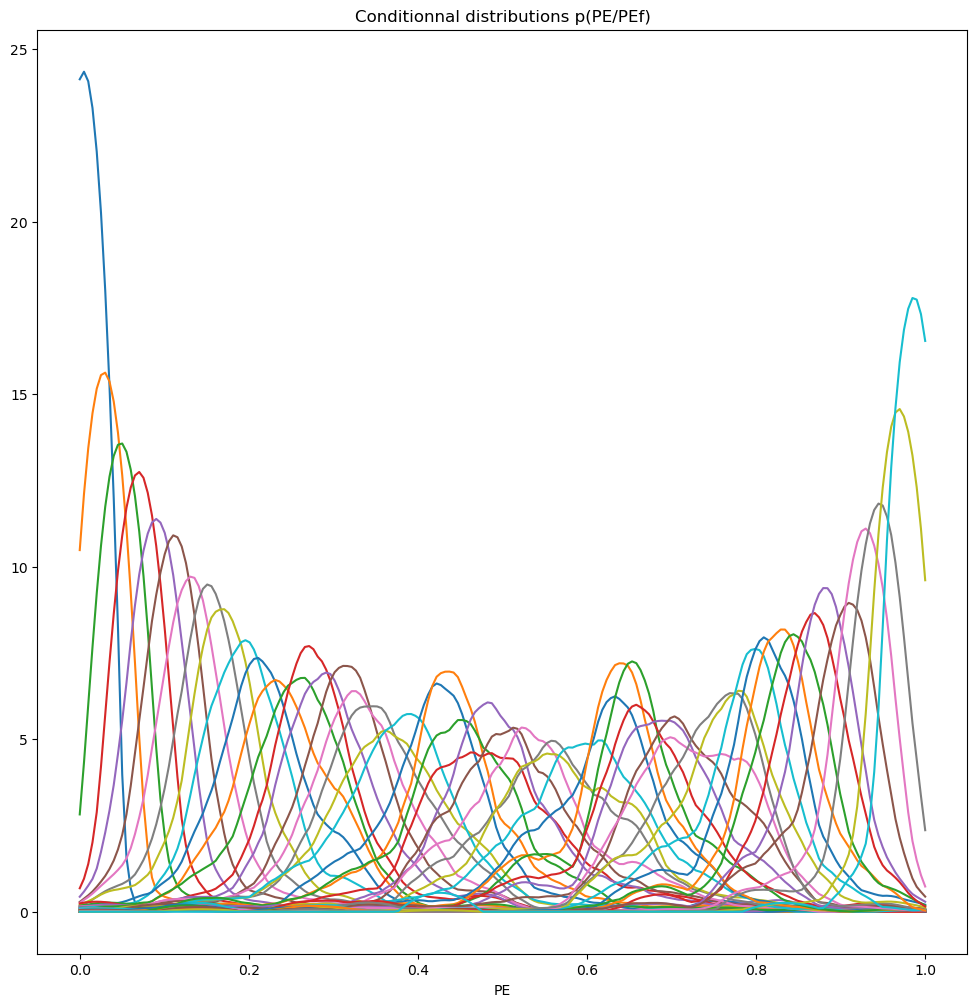

In [233]:
plt.figure(figsize=(12,12))

cond._plot_conditional_distributions()

In [178]:
# Verification that conditional distributions are normalized that is $\mathbb{E}_{PE}[1. / PE_f]=1$ 
one = lambda x: 1.0
for pef in [0.1, 0.2, 0.5, 0.8]:
    print(cond.expectation(one, pef))

0.9999999999999996
0.9999999999999998
0.9999999999999998
1.0000000000000002


Implementation of the best strategy conditionned to a deterministic prediction, and given by 
$$PE_c^* = \textrm{ArgMin}_{PE_c}\mathbb{E}_{PE} [L(PE_c,PE)/PEf] = \textrm{ArgMin}_{PE_c}\widehat{L}_f(PE_c, PE_f).$$

In [183]:
class DeterministicPEcStrategy(PEcStrategy):
    
    def __init__(self, cond_distribution, *args, optim='argmin', **kwargs):
        super().__init__(*args, **kwargs)
        self._optimizer = optim
        self._cond = cond_distribution
    
    def hat_loss(self,pec):
        loc_loss = lambda pe: loss(pec,pe)        
        return self._cond.expectation(loc_loss, self._pef)
    
    def set_weather_information(self, pef):
        self._pef = pef
    
    def plot_hat_loss(self):
        """ Plot of the loss function for a given weather situation """
        '''
        pec = np.linspace(0,1,200)
        plt.plot(pec,[self.hat_loss(p) for p in pec])
        plt.xlabel("PEc")
        '''
        super().plot_hat_loss()
        plt.title(f'Loss E_PE[ l(PEc,PE)/PEf] as a function of PEc\n for PEf={self._pef}')
        

In [184]:
strategies['deterministic'] = DeterministicPEcStrategy(cond)

**Illustration for some given PEf**

0.21105527638190955 5.527638190954767
0.3969849246231156 -0.7537688442211116
0.6130653266331658 2.1775544388609736
0.7989949748743719 -0.1256281407035209


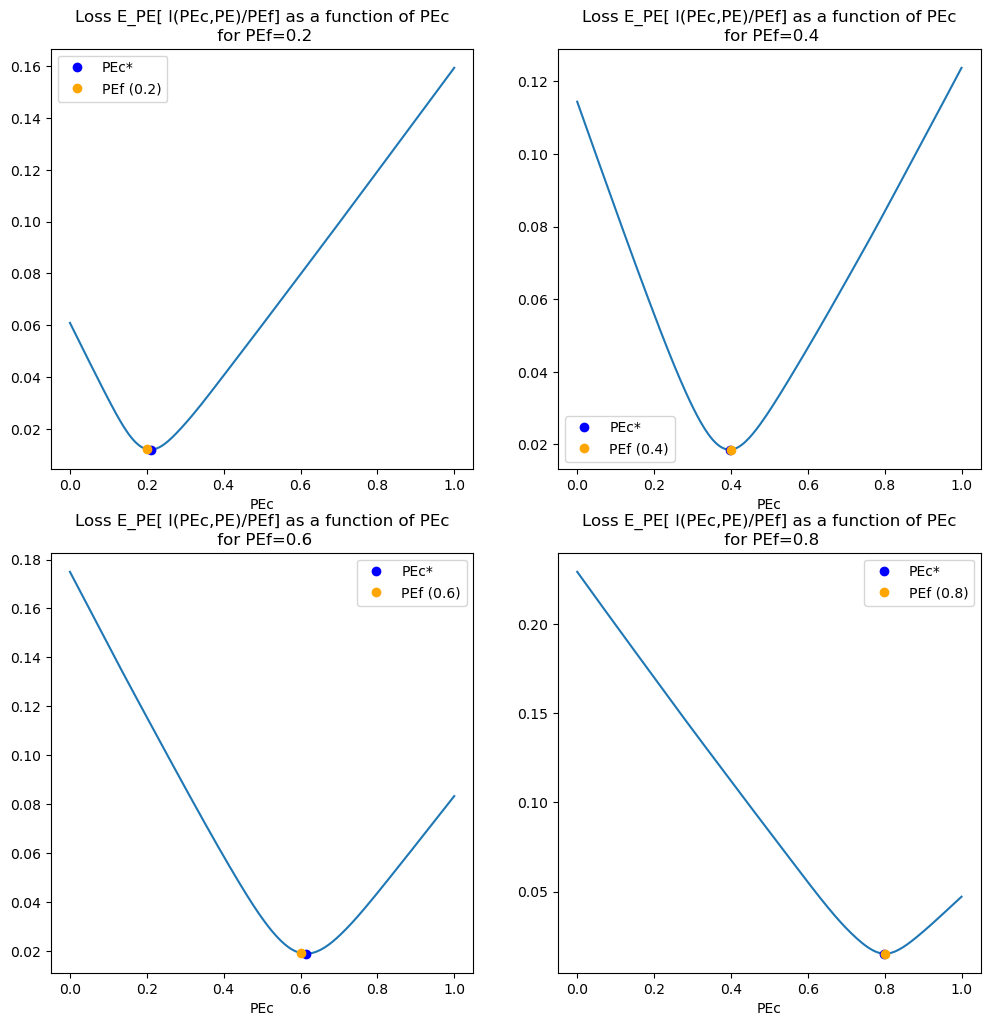

In [191]:
rel_error = lambda pec_star,pef : (pec_star-pef)/pef*100
strategy = strategies['deterministic']
plt.figure(figsize=(12,12))
for k,pef in enumerate([0.2, 0.4, 0.6, 0.8]):
    plt.subplot(221+k)
    strategy.set_weather_information(pef)
    strategy.plot_hat_loss()
    pec_star = strategy.get_pec()
    print(pec_star, rel_error(pec_star, pef))    
    plt.plot(pec_star, strategy.hat_loss(pec_star),'ob', label='PEc*')
    plt.plot(pef, strategy.hat_loss(pef),'o',color='orange', label=f'PEf ({pef})')
    plt.legend()


<div style="margin:0 50px 0 50px">
<h4><b>Question: </b></h4>
<div style="background:MistyRose">
Plot the optimal value provided from the optimization of $\widehat{L}_f$ for a given prediction of $PE_f$, and compare the resulting $PE_c$ with the intiale $PE_f$ provided.
</div>
</div>

### **6.3 Best $PE_c$ from ensemble prediction system $\widehat{L}_\textrm{eps.} (PE_c, PE_\textrm{eps.})=\mathbb{E}_{PE_f}\left[\mathbb{E}_{PE} [L(PE_c,PE)/PEf]\right].$**

This strategy is performed from the class defined now

In [192]:
class EnsemblePEcStrategy(DeterministicPEcStrategy):
    
    
    def hat_loss(self,pec):
        loc_loss = lambda pe: loss(pec,pe)        
        return np.mean([self._cond.expectation(loc_loss, pef) for pef in self._pe_eps])
    
    def set_weather_information(self, eps):
        self._pe_eps = eps        
    
    def plot_hat_loss(self):
        """ Plot of the loss function for a given weather situation """
        '''
        pec = np.linspace(0,1,200)
        plt.plot(pec,[self.hat_loss(p) for p in pec])
        plt.xlabel("PEc")
        '''
        super(DeterministicPEcStrategy).plot_hat_loss()
        plt.title(f'Loss E_PE[ l(PEc,PE)/PEf] as a function of PEc\n for mean(PEf)={np.mean(self._pef_eps)}')

In [193]:
strategies['ensemble'] = EnsemblePEcStrategy(cond)

## **7 Evaluation of these strategy on an independent period**
Evaluation of the strategies

**Design of the evaluation period**

For the valisation period we consider the same EnKF prediction system and evaluation the different strategies along a large period.

In [194]:
xt = assim_nature_db[-1]
Xf = assim_eps_db[-1]

In [195]:
strategies

{'climate': <__main__.ClimatePEcStrategy at 0x7f1e09cf7400>,
 'deterministic': <__main__.DeterministicPEcStrategy at 0x7f1e1c6a8df0>,
 'ensemble': <__main__.EnsemblePEcStrategy at 0x7f1e09a2f250>}

In [196]:
#EnKF

nb_cycles_evaluation = (2*365)*4 # Long period for robust evaluation of the strategies
nb_cycles_evaluation = 100  # Short period for intermediate evaluation of the strategies.

print("Compute assimilation cycles over a long (short) period for robust (intermediate) evaluation ")

evaluation_db = { 'PEc-'+key:[] for key in strategies}
evaluation_db['PEt'] = [] # True observed value
evaluation_db['PEf'] = [] # Prediction from the forecast
evaluation_db['PEeps'] = [] # Prediction from the ensemble prediction system (EPS)

for k in valeco.range_bar(nb_cycles_evaluation):
    #
    # Analysis state
    #
    # Build synthetic observations to mimic real observations of Nature
    yo = xt + stdo*np.random.normal(size=3)
    
    # Estimate the covariance matrix    
    ef = (np.asarray(Xf) - np.asarray(Xf).mean(axis=0)).T
    Pf = 1/Ne* ef@ef.T
    # Compute Kalman's gain matrix K
    Ke = Pf@H.T@np.linalg.inv(H@Pf@H.T+R)
    # Assimilate base on error perturbation
    def assim(xf, yo):
        d = yo.T - H@xf.T
        xa = xf.T+Ke@d
        return xa.T
    
    perturbed_obs_gen = (yo+stdo*np.random.normal(size=3) for k in range(Ne))
    
    Xa = []
    for xf,yop in zip(Xf, perturbed_obs_gen):
        Xa.append(assim(xf, yop))
    
    
    #
    # Forecast step
    #
    xft = nature.predict(window_6h, xt)[-1]
    xt = xft
    
    ens_traj = model.ensemble_forecast(window_6h, Xa)    
    Xf = ens_traj[window_6h[-1]]
    
    # Evaluation of the strategies on the forecast of PEc
    
    # True observed power wind
    pe_t = powerplant.FF2PE(nature.state2FF(xt))
    
    # Forecasted powerwind (from mean ensemble of forecasts)
    xf = np.asarray(Xf).mean(axis=0) # mean of the ensemble.
    pe_f = powerplant.FF2PE(nature.state2FF(xf))
    
    # Ensemble of powerwind forecasts    
    pe_eps = wind_power(wind(Xf))
    
    evaluation_db['PEt'].append(pe_t)
    evaluation_db['PEf'].append(pe_f)
    evaluation_db['PEeps'].append(pe_eps)
    
    # Strategies
    
    for key, strategy in strategies.items():
        # Set weatehr information depending on the strategies
        if key == 'climate':
            # 1 -- Climate optmized PEc*
            # Nothing to do 
            pass
        
        elif key=='deterministic':
            # 2 -- Deterministic optmized PEc*
            strategy.set_weather_information(pe_f)
            
        elif key=='ensemble':
            # 3 -- Ensemble optmized PEc*
            strategy.set_weather_information(pe_eps)

        pe_c = strategy.get_pec() 
        evaluation_db['PEc-'+key].append(pe_c)


Compute assimilation cycles over a long (short) period for robust (intermediate) evaluation 


IntProgress(value=0, description='Loading:')

**Computation of the loss along the period**

In [221]:
losses = {}
for method in strategies:
    losses[method] = [loss(pec, pe) for pec, pe in zip(evaluation_db['PEc-'+method], evaluation_db['PEt'])]
losses['raw prediction'] = [loss(pec, pe) for pec, pe in zip(evaluation_db['PEf'], evaluation_db['PEt'])]

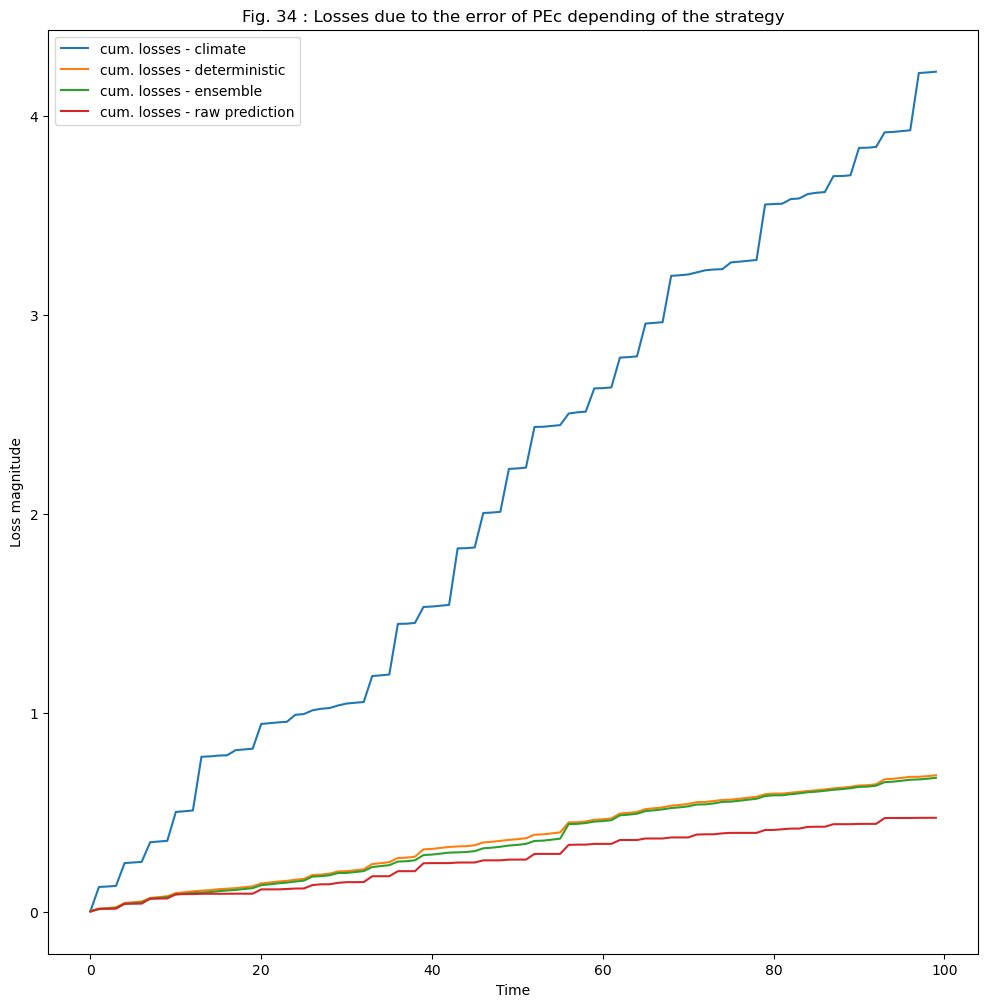

In [222]:
plt.figure(figsize=(12,12))
for method, data in losses.items():
    plt.plot(np.cumsum(data),label='cum. losses - '+method)
plt.legend()
plt.title(Fignum()+"Losses due to the error of PEc depending of the strategy")
plt.xlabel("Time")
plt.ylabel("Loss magnitude");

<div style="margin:0 50px 0 50px">
<h4><b>Question: </b></h4>
<div style="background:MistyRose">
    <ol>
<li> Detail the resulting plot
<li> Give some explainations or perspective to understand the results.
    </ol>
</div>
</div>

<div style="margin:0 50px 0 50px">
<h4><b>Question: </b></h4>
<div style="background:MistyRose">
Try other strategies for the computation of $PE_c^*$ for instance the computation from the mode of the conditionnal distribution.
</div>
</div>

## Conclusion

<div style="margin:0 50px 0 50px">
<h4><b>Question: </b></h4>
<div style="background:MistyRose">
Write conclusions of this work.. 
</div>
</div>

##  References for further reading and developpements
    
P. Pinson, J. Juban, and G. Kariniotakis, “On the Quality and Value of Probabilistic Forecasts of Wind Generation,” in International Conference on Probabilistic Methods Applied to Power Systems, Stockholm, 2006.

E. D. Castronuovo et al., “An integrated approach for optimal coordination of wind power and hydro pumping storage,” Wind Energy, vol. 17, no. 6, pp. 829–852, Mar. 2013, doi: 10.1002/we.1600.

J. W. Taylor and J. Jeon, “Forecasting wind power quantiles using conditional kernel estimation,” Renewable Energy, vol. 80, pp. 370–379, Aug. 2015, doi: 10.1016/j.renene.2015.02.022.